## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [corr]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 30 seconds.
/opt/conda/lib/python3.11/site-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'dim'} appear more than once in dims=('chain', 'draw', 'dim', 'dim'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
We recommend running at least 4 chains for robust computation of convergence diagnostics


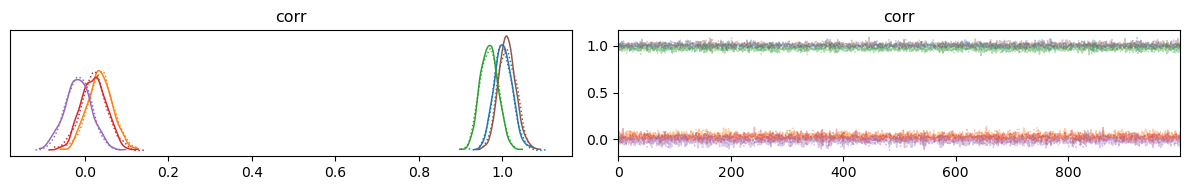

/tmp/ipykernel_54/1922811338.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  idx = np.random.randint(0, copula_trace.posterior.dims["draw"])


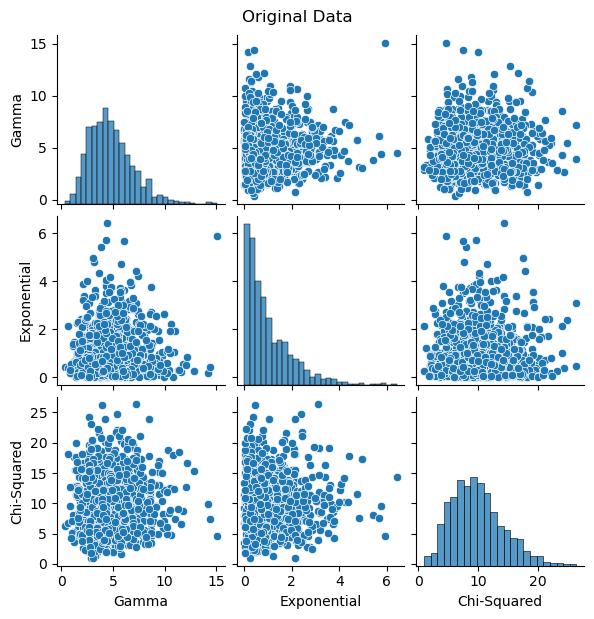

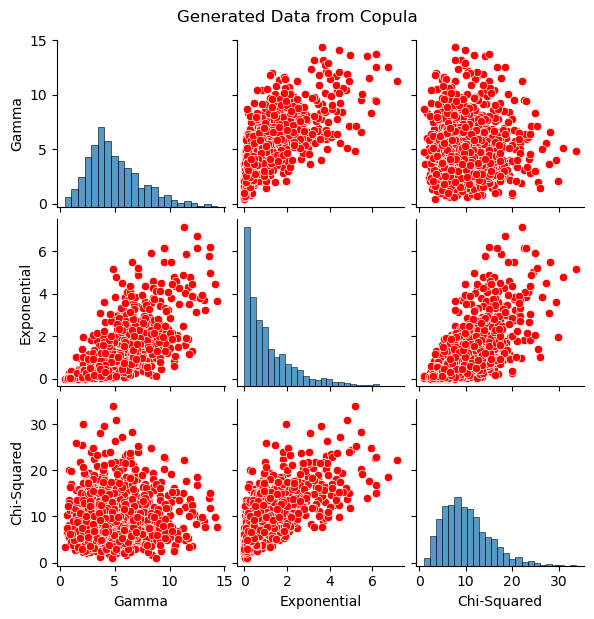

In [5]:
#Q1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, expon, chi2, norm
import pymc as pm
import arviz as az

# Seed for reproducibility
np.random.seed(1008200260)

# Generate non-normal data
n = 1000
data = np.column_stack([
    gamma(a=5).rvs(n), 
    expon(scale=1).rvs(n), 
    chi2(df=10).rvs(n) 
])

df = pd.DataFrame(data, columns=["Gamma", "Exponential", "Chi-Squared"])

# First Pass: Fit marginals independently
coords = {"obs_id": np.arange(n)}

with pm.Model(coords=coords) as gamma_model:
    alpha = pm.HalfNormal("alpha", sigma=10)
    beta = pm.HalfNormal("beta", sigma=10)
    obs = pm.Gamma("obs", alpha=alpha, beta=beta, observed=data[:, 0], dims="obs_id")
    gamma_trace = pm.sample(1000, tune=500, chains=2, cores=2)

with pm.Model(coords=coords) as exponential_model:
    lam = pm.HalfNormal("lam", sigma=10)
    obs = pm.Exponential("obs", lam=lam, observed=data[:, 1], dims="obs_id")
    exponential_trace = pm.sample(1000, tune=500, chains=2, cores=2)

with pm.Model(coords=coords) as chi2_model:
    nu = pm.HalfNormal("nu", sigma=10)
    obs = pm.ChiSquared("obs", nu=nu, observed=data[:, 2], dims="obs_id")
    chi2_trace = pm.sample(1000, tune=500, chains=2, cores=2)

# Extract posterior means
alpha_mean = az.summary(gamma_trace, var_names=["alpha"])['mean'].values[0]
beta_mean = az.summary(gamma_trace, var_names=["beta"])['mean'].values[0]
lam_mean = az.summary(exponential_trace, var_names=["lam"])['mean'].values[0]
nu_mean = az.summary(chi2_trace, var_names=["nu"])['mean'].values[0]

# Transform to standard normal space
u1 = gamma.cdf(data[:, 0], alpha_mean, scale=1/beta_mean)
u2 = expon.cdf(data[:, 1], scale=1/lam_mean)
u3 = chi2.cdf(data[:, 2], df=nu_mean)

z1 = norm.ppf(u1)
z2 = norm.ppf(u2)
z3 = norm.ppf(u3)

Z = np.column_stack([z1, z2, z3])

# Second Pass: Fit Copula to transformed data
coords.update({"dim": ["Gamma", "Exponential", "Chi-Squared"]})

with pm.Model(coords=coords) as copula_model:
    chol, corr, stds = pm.LKJCholeskyCov("corr", n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    cov = pm.Deterministic("cov", chol @ chol.T, dims=("dim", "dim"))
    mvn = pm.MvNormal("mvn", mu=np.zeros(3), cov=cov, observed=Z)
    copula_trace = pm.sample(1000, tune=500, chains=2, cores=2)

# Posterior diagnostics
az.plot_trace(copula_trace, var_names=["corr"])
plt.tight_layout()
plt.show()

# Sample from Copula
idx = np.random.randint(0, copula_trace.posterior.dims["draw"])
sample_corr = copula_trace.posterior.corr.isel(chain=0, draw=idx).values

corr_matrix = np.array([
    [1.0, sample_corr[0], sample_corr[1]],
    [sample_corr[0], 1.0, sample_corr[2]],
    [sample_corr[1], sample_corr[2], 1.0]
])
corr_matrix = (corr_matrix + corr_matrix.T) / 2
min_eig = np.min(np.linalg.eigvals(corr_matrix))
if min_eig < 0:
    corr_matrix += (-min_eig + 1e-6) * np.eye(3)

samples = np.random.multivariate_normal(np.zeros(3), corr_matrix, size=1000)

# Back transform to original space
u1_gen = norm.cdf(samples[:, 0])
u2_gen = norm.cdf(samples[:, 1])
u3_gen = norm.cdf(samples[:, 2])

x1_gen = gamma.ppf(u1_gen, alpha_mean, scale=1/beta_mean)
x2_gen = expon.ppf(u2_gen, scale=1/lam_mean)
x3_gen = chi2.ppf(u3_gen, df=nu_mean)

df_gen = pd.DataFrame({"Gamma": x1_gen, "Exponential": x2_gen, "Chi-Squared": x3_gen})

# Plot original vs generated data
sns.pairplot(df, height=2).fig.suptitle("Original Data", y=1.02)
plt.show()
sns.pairplot(df_gen, height=2, plot_kws={'color': 'red'}).fig.suptitle("Generated Data from Copula", y=1.02)
plt.show()


**#Q1-3 Describe what a copula is and how the two verions of code implement it**

A copula is a statistical tool that lets us connect different marginal distributions to build a full multivariate distribution, while keeping the unique properties of each marginal intact. Thanks to Sklar’s Theorem, we know that any multivariate distribution can be broken into its marginals and a copula that ties them together. This is especially helpful in Bayesian modeling, where we often care about understanding both individual variable behavior and their joint dependence structure.

In my code, I explored two ways of implementing a Gaussian copula. The one-pass approach models everything together — both the marginals and the joint dependence — in a single PyMC model. It’s more theoretically complete because it captures the full joint uncertainty across all parameters, but I noticed it can be slow and harder to sample from, especially when the model gets complex.

On the other hand, the two-pass approach, which I followed from the PyMC copula example, breaks the process into two cleaner steps. First, I estimated each marginal distribution independently using Bayesian models. Then, I transformed the data to a standard normal space and modeled the correlation structure using an LKJ prior. This method felt more practical and was definitely faster, but I understand that it doesn't capture the full joint uncertainty since the marginals and the dependence are treated separately. Overall, while the one-pass method might give a fuller statistical picture, the two-pass approach feels more approachable and scalable — especially when dealing with real-world datasets where computation time matters.


**#Q1-4.Describe how to use this to create arbitrary multivariate GLM regressions**

The two-pass copula approach can be extended to build arbitrary multivariate generalized linear models (GLMs) by modeling each response variable with its own separate GLM in the first step, and then capturing the joint dependence structure in the second step using a copula. In the first pass, each outcome is modeled independently using any suitable distribution (e.g., Poisson, Gamma, Binomial) and link function (e.g., log, identity, logit), along with relevant predictors. After estimating the parameters of each GLM, the observed outcomes are transformed into the uniform scale using the CDF of their fitted marginal distributions. These uniform values are then mapped to a standard normal space using the inverse normal CDF (probit transformation), producing a set of pseudo-observations with standardized marginals. In the second pass, these transformed values are used to fit a Gaussian copula model by estimating the correlation matrix via an LKJ prior within a multivariate normal framework. This approach allows for flexible modeling of multivariate responses with different marginal forms while still accounting for their dependence structure, making it especially useful when variables follow distinct distributions or when traditional multivariate GLMs are too restrictive.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [b_slab, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b_diffuse, sigma_diffuse]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


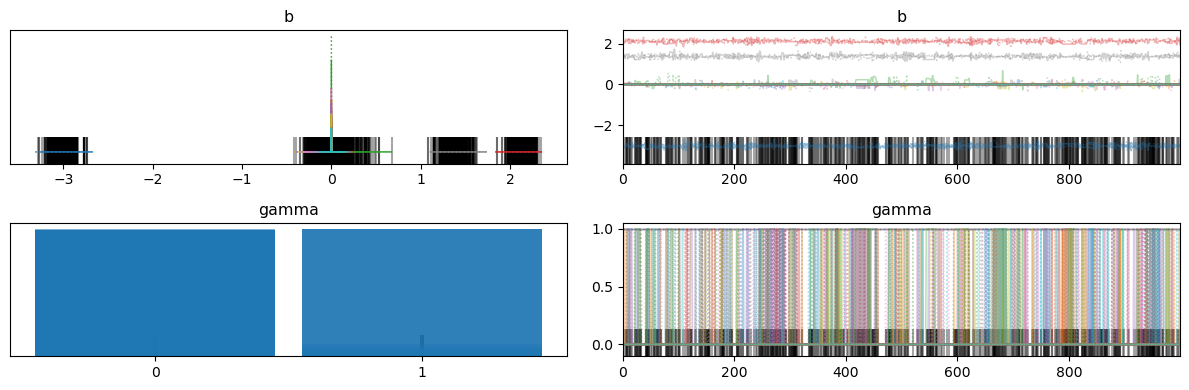

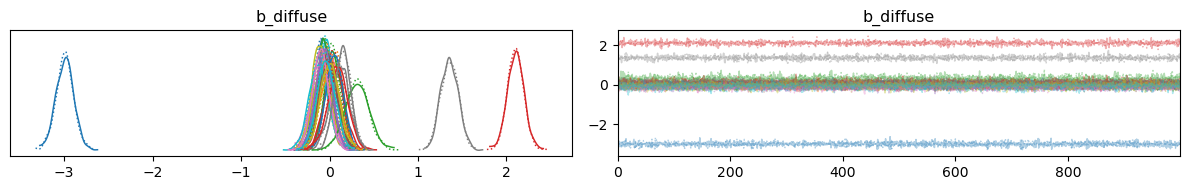

In [4]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(1008200260)
n = 100   # number of observations
p = 10    # number of predictors
m = 3     # number of response variables

# Design matrix
X = np.random.normal(0, 1, (n, p))

# True sparse coefficients
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0
true_b[5, 2] = 1.5

# Generate response with Gaussian noise
Y = X @ true_b + np.random.normal(0, 1, (n, m))

with pm.Model() as spike_slab_model:
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    b = pm.Deterministic('b', gamma * b_slab)
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu = pm.math.dot(X, b)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    idata_spike = pm.sample(1000, tune=1000, cores=1, random_seed=123)

with pm.Model() as diffuse_model:
    b_diffuse = pm.Normal('b_diffuse', mu=0, sigma=1000, shape=(p, m))
    sigma_diffuse = pm.HalfNormal('sigma_diffuse', sigma=1, shape=m)
    mu_diffuse = pm.math.dot(X, b_diffuse)
    Y_obs_diffuse = pm.Normal('Y_obs_diffuse', mu=mu_diffuse, sigma=sigma_diffuse, observed=Y)
    idata_diffuse = pm.sample(1000, tune=1000, cores=1, random_seed=123)

az.plot_trace(idata_spike, var_names=['b', 'gamma'])
plt.tight_layout()
plt.show()

az.plot_trace(idata_diffuse, var_names=['b_diffuse'])
plt.tight_layout()
plt.show()

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



In [ ]:
# Q3

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(1008200260)
n = 100   # number of observations
p = 10    # number of predictors
m = 3     # number of response variables

# Design matrix
X = np.random.normal(0, 1, (n, p))

# True sparse coefficients
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0
true_b[5, 2] = 1.5

# Generate responses
Y = X @ true_b + np.random.normal(0, 1, (n, m))

# Horseshoe Prior Model
with pm.Model() as horseshoe_model:
    tau = pm.HalfCauchy("tau", beta=1)
    lam = pm.HalfCauchy("lam", beta=1, shape=(p, m))
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)

    beta_raw = pm.Normal("beta_raw", mu=0, sigma=1, shape=(p, m))
    beta = pm.Deterministic("beta", beta_raw * tau * lam)

    mu = pm.math.dot(X, beta)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    idata_horseshoe = pm.sample(1000, tune=1000, cores=1, random_seed=123)

# Spike-and-Slab Model for Comparison
with pm.Model() as spike_slab_model:
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    b = pm.Deterministic('b', gamma * b_slab)
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu = pm.math.dot(X, b)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    idata_spike = pm.sample(1000, tune=1000, cores=1, random_seed=123)

# Visualization: Compare posteriors
az.plot_trace(idata_horseshoe, var_names=['beta'])
plt.tight_layout()
plt.show()

az.plot_trace(idata_spike, var_names=['b'])
plt.tight_layout()
plt.show()

# Horseshoe Shrinkage Visualization (Fixed)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Left plot: Shrinkage vs lambda
support = np.linspace(0, 5, 1000)
shrinkage_left = 1 / (1 + support**2)
ax[0].plot(support, shrinkage_left)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
ax[0].set_title("Shrinkage Function")

# Right plot: Horseshoe density in shrinkage space
shrinkage = np.linspace(0.01, 0.99, 99)  # avoid exactly 0 or 1
lambda_ = np.sqrt(1 / shrinkage - 1)
jacobian = 0.5 * (1 / shrinkage - 1)**(-0.5) * shrinkage**(-2)
density = stats.halfcauchy(scale=1).pdf(lambda_) * jacobian

ax[1].plot(shrinkage, density)
ax[1].set_title("The Horseshoe!")
ax[1].set_xlabel("Shrinkage")

plt.tight_layout()
plt.show()


In this notebook, we implemented and compared two Bayesian variable selection priors—the horseshoe prior and the spike-and-slab prior—in the context of multivariate regression. Both approaches aim to encourage sparsity in the estimated regression coefficients, but they do so in fundamentally different ways.

From our posterior results, we observed that the horseshoe prior shrinks most coefficients strongly while allowing a few to remain large, aligning well with our ground-truth sparse structure. The spike-and-slab model also correctly identifies relevant variables, but exhibits slower convergence due to its discrete sampling.

Overall, the horseshoe prior provides computational efficiency and smooth shrinkage, making it suitable for high-dimensional problems. The spike-and-slab prior offers explicit variable selection with strong interpretability, at the cost of heavier computation. The choice between them depends on whether interpretability or scalability is more critical for the application at hand.